# Planar data classification with one hidden layer

Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


## 1 - Packages ##

Let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets,linear_model

#from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [99]:
def sigmoid(z):
    
    s = 1/(1+np.exp(-z))
    
    return s

def plot_decision_boundary(x,y,pred_fn):
    
    x1min = x[0,:].min()-1
    x1max = x[0,:].max()+1
    
    x2min = x[1,:].min()-1
    x2max = x[1,:].max()+1
    
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
     
    xx = np.arange(x1min,x1max,0.01)
    yy = np.arange(x2min,x2max,0.01)
    
    #create 2d version from 1d vectors
    xx,yy = np.meshgrid(xx,yy)
    
    
    # Predict the function value for the whole grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = pred_fn(grid)

    #Show the classifier boundary using a color plot
    
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral )
    plt.scatter(x[0, :], x[1, :], c=y, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    
    plt.show()

In [3]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class; 200 points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # Placeholder for input data => (400,2)
    Y = np.zeros((m,1), dtype='uint8') # yis (400,1) : labels vector (0 for red, 1 for blue)
    a = 4 # maximum radius of the flower petals, controls scale of the data

    for j in range(2): #Loop runs twice — once for class 0 and once for class 1.
        
        ix = range(N*j,N*(j+1))
        # First loop: ix = range(0, 200) → class 0
        # Second loop: ix = range(200, 400) → class 1
        
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 
        # t is like an angle (theta) in polar coordinates.
        # linspace defines the angle spread for each class (e.g., from 0 to ~3.12 radians).
        # np.random.randn(N)*0.2 adds random noise to vary the angle → makes the pattern
        
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        # r is the radius (distance from origin). sin(4*t) causes a flower petal shape with 4 petals.
        
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        # Converts polar coordinates (r, t) into Cartesian (x, y) using: x = r * sin(t) and y = r * cos(t)
        
        Y[ix] = j
        # Labels these points with class j (0 or 1).
        
    X = X.T
    Y = Y.T
    
    return X, Y

## 2_LOAD DATASET

In [4]:
X, Y = load_planar_dataset()

In [5]:
print("X shape: ",X.shape)
print("Y shape: ",Y.shape)

X shape:  (2, 400)
Y shape:  (1, 400)


X
- a numpy-array (matrix) X that contains your features (x1, x2)
- The shape of X is: (2, 400)       

Y   
- a numpy-array (vector) Y that contains your labels (red:0, blue:1)
- The shape of Y is: (1, 400)

In [6]:
Y.T[:,0].shape

(400,)

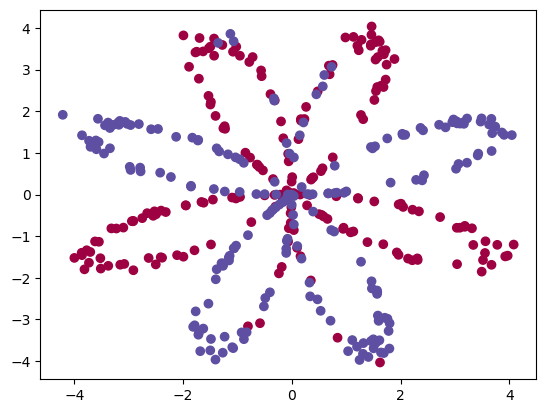

In [7]:
#Visualise the data

plt.scatter(X[0,:], X[1,:], c=Y, cmap=plt.cm.Spectral)

## 3_Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [8]:
from sklearn.linear_model import LogisticRegressionCV

log_obj = LogisticRegressionCV()
log_obj.fit(X.T,Y.T[:,0])


LogisticRegressionCV()

In [9]:
Y.size

400

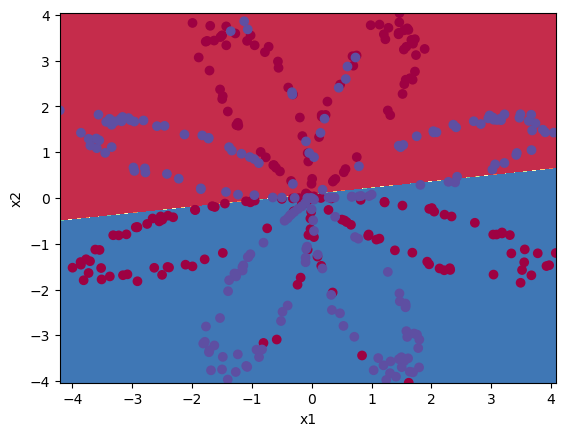

accuracy of logistic regression:  47.0  % of correctly classified data points


In [10]:
# Plot the decision boundary for logistic regression
pred_fn = lambda x: log_obj.predict(x)
plot_decision_boundary(X,Y,pred_fn)

#Print accuracy

y_pred = log_obj.predict(X.T)

accuracy = (float(np.dot(Y,y_pred)+np.dot(1-Y,1-y_pred))/float(Y.size))*100
print("accuracy of logistic regression: ", accuracy , " % of correctly classified data points")

Interpretation: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now!

## 4_Neural Network model - 1 hidden layer

## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="https://www.deardon.win/2019/02/06/theory-and-code-for-building-first-neural-network/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$  

$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$

$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$

$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$

$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$


**Reminder**: The general methodology to build a Neural Network is to:   
    1. Define the neural network structure ( # of input units,  # of hidden units, etc).  
    2. Initialize the model's parameters  
    3. Loop:  
        - Implement forward propagation   
        - Compute loss   
        - Implement backward propagation to get the gradients   
        - Update parameters (gradient descent)   

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure ####

**Exercise**: Define three variables:
- n_x: the size of the input layer
- n_h: the size of the hidden layer (set this to 4) 
- n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [13]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)

In [14]:
#X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X, Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


**Expected Output** (these are not the sizes you will use for your network, they are just used to assess the function you've just coded).

<table>
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
</table>

### 4.2 - Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [66]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(2)
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2
        
    }
    
    return parameters
                    
    

In [67]:
#n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print(f"W1 =  {str(parameters['W1'])} \tshape: {parameters['W1'].shape}")
print(f"b1 =  {str(parameters['b1'])} \tshape: {parameters['b1'].shape}")
print(f"W2 =  {str(parameters['W2'])} \tshape: {parameters['W2'].shape}")
print(f"b2 =  {str(parameters['b2'])} \tshape: {parameters['b2'].shape}")



W1 =  [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] 	shape: (4, 2)
b1 =  [[0.]
 [0.]
 [0.]
 [0.]] 	shape: (4, 1)
W2 =  [[-0.01057952 -0.00909008  0.00551454  0.02292208]] 	shape: (1, 4)
b2 =  [[0.]] 	shape: (1, 1)


**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>

### 4.3 - Forward_propagation ####

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [30]:
print(f"W1 shape: {parameters['W1'].shape}")
print(f"b1 shape: {parameters['b1'].shape}")
print(f"W2 tshape: {parameters['W2'].shape}")
print(f"b2 shape: {parameters['b2'].shape}")


W1 shape: (4, 2)
b1 shape: (4, 1)
W2 tshape: (1, 4)
b2 shape: (1, 1)


In [28]:
X.shape

(2, 400)

In [29]:
Y.shape

(1, 400)

In [102]:
def forward_propagation(X,parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    w1 = parameters["W1"]
    b1 = parameters["b1"]
    w2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(w1,X) + b1  #Z1.shape == (4,400)
    A1 = np.tanh(Z1) #A1.shape == (4,400)
    Z2 = np.dot(w2,A1) + b2 #Z2.shape == (1,400)
    A2 = sigmoid(Z2) #A2.shape == (1,400)
    
    assert (A2.shape == (1,X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache  

In [103]:
#X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

-0.4807808187527064 0.010061621327454705 -0.10653053537788879 0.4889232874492911


**Expected Output**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198  0.091999045227  -1.30766601287  0.212877681719 </td> 
  </tr>
</table>

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. To help you, we give you how we would have implemented
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(you can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).  
Note that if you use `np.multiply` followed by `np.sum` the end result will be a type `float`, whereas if you use `np.dot`, the result will be a 2D numpy array.  We can use `np.squeeze()` to remove redundant dimensions (in the case of single float, this will be reduced to a zero-dimension array). We can cast the array as a type `float` using `float()`.

In [85]:
def compute_cost(A2,Y):
    
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    m = Y.shape[1]
    
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),1-Y)
    cost = - np.sum(logprobs)/m
    
    cost = float(np.squeeze(cost)) # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [86]:
#A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y)))

cost = 0.6930480201239823


### 4.4 - Backward_propagation ####

**Question**: Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="https://pylessons.com/media/Tutorials/Neural-network-single-layer/Neural-network-single-layer-part3/grad_summary.jpg" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [68]:
def backward_propagation(parameters,cache,X,Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = Y.shape[1]
    
    W1 = parameters["W1"] 
    W2 = parameters["W2"]
    
    A2 = cache["A2"]
    Z2 = cache["Z2"]
    A1 = cache["A1"]
    Z1 = cache["Z1"]
    
    dZ2 = A2 - Y # (1,400)
    dW2 = (1/m)* np.dot(dZ2,A1.T) # (1,400) . (400,4) => (1,4)
    db2 = (1/m)* np.sum(dZ2, axis=1, keepdims=True) # (1,1)
     
    dZ1 = np.dot(W2.T,dZ2) * (1-np.power(A1,2))  #[(4,1) . (1,400)] * (4,400) => (4,400)
    dW1 = (1/m)* np.dot(dZ1,X.T) # (4,400) . (400,2) => (4,2)
    db1 = (1/m)* np.sum(dZ1, axis=1, keepdims=True) # (4,1)
    
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
    

In [69]:
#parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X, Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00023606 -0.00207914]
 [ 0.0002091  -0.00178201]
 [-0.00012051  0.0010843 ]
 [-0.00051496  0.00449162]]
db1 = [[ 1.06848030e-07]
 [-9.70907252e-07]
 [-7.20012658e-08]
 [ 3.03048452e-07]]
dW2 = [[-1.75478714e-05  3.70240274e-03 -1.25686736e-03 -2.55725650e-03]]
db2 = [[-1.0892314e-05]]


**Question**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.


In [70]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    #parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #gradients
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    #update parameters
    
    W1 = W1 - (learning_rate * dW1)
    b1 = b1 - (learning_rate * db1)
    W2 = W2 - (learning_rate * dW2)
    b2 = b2 - (learning_rate * db2)
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
    

In [71]:
#parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00445085  0.0019323 ]
 [-0.02161288  0.01854112]
 [-0.01778975 -0.00971864]
 [ 0.00564676 -0.01784282]]
b1 = [[-1.28217636e-07]
 [ 1.16508870e-06]
 [ 8.64015190e-08]
 [-3.63658142e-07]]
W2 = [[-0.01055846 -0.01353296  0.00702278  0.02599079]]
b2 = [[1.30707768e-05]]


### 4.5 - Integrate parts 4.1, 4.2, 4.3 and 4.4 in nn_model() ####

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [91]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    
    #1. layer size
    n_x = layer_sizes(X,Y)[0]
    n_y = layer_sizes(X,Y)[2]
    
    #2. initialise parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(num_iterations):
    
        #3. forward propagation 
        A2,cache = forward_propagation(X,parameters)

        #3_1. compute cost
        cost = compute_cost(A2,Y)

        #4. backward propagtion
        grads = backward_propagation(parameters,cache,X,Y)

        #4_1. update parameters
        parameters = update_parameters(parameters, grads)
    
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [92]:
#X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X, Y, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219469
Cost after iteration 9000: 0.218561
W1 = [[  0.1444598   -9.68512293]
 [-11.13257775   3.33889357]
 [-11.46576897 -13.41880224]
 [  9.25557823 -10.19783336]]
b1 = [[ 0.01582663]
 [-0.40866602]
 [-0.0649457 ]
 [ 0.01699896]]
W2 = [[-11.98568926   3.44423575   6.15141045  10.52134585]]
b2 = [[-0.06602675]]


### 4.6 Predictions

**Question**: Use your model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [93]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    
    A2, cache = forward_propagation(X,parameters)
    predictions = (A2>0.5).astype(int)
    
    return predictions

In [94]:
#parameters, X_assess = predict_test_case()

predictions = predict(parameters, X)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.4875


It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219469
Cost after iteration 9000: 0.218561


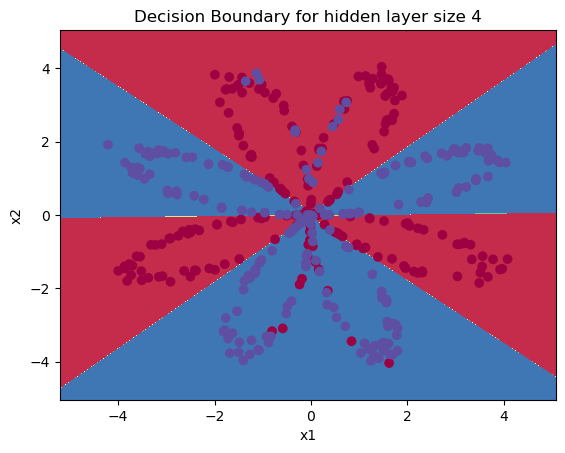

In [105]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plt.title("Decision Boundary for hidden layer size " + str(4))
plot_decision_boundary(X, Y, lambda x: predict(parameters, x.T))


In [106]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


### 5 - Tuning hidden layer size ###

Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes.

<Figure size 1000x2000 with 0 Axes>

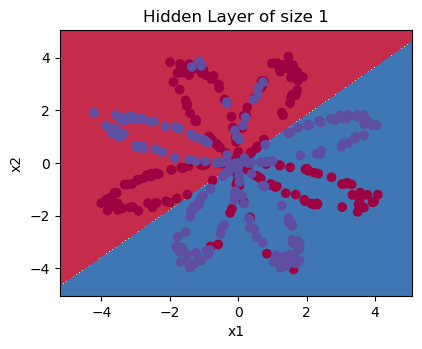

Accuracy for 1 hidden units: 67.5 %


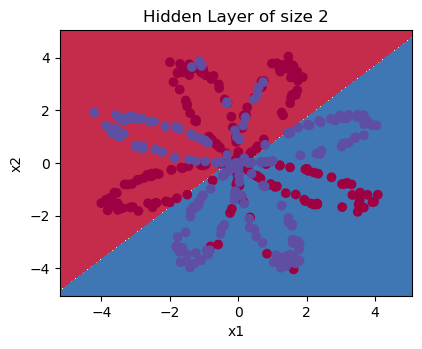

Accuracy for 2 hidden units: 67.25 %


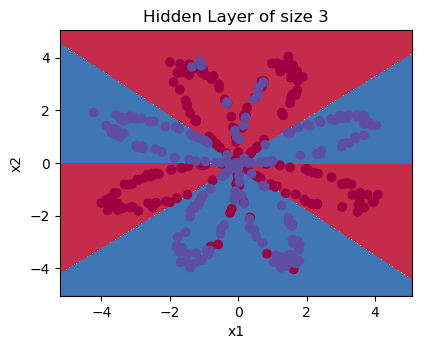

Accuracy for 3 hidden units: 90.75 %


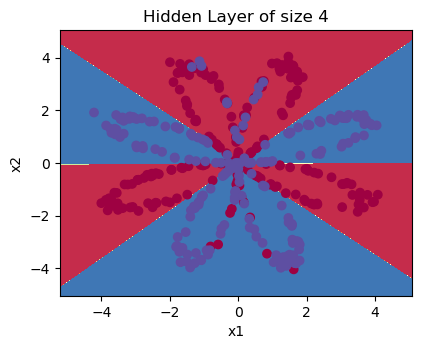

Accuracy for 4 hidden units: 90.5 %


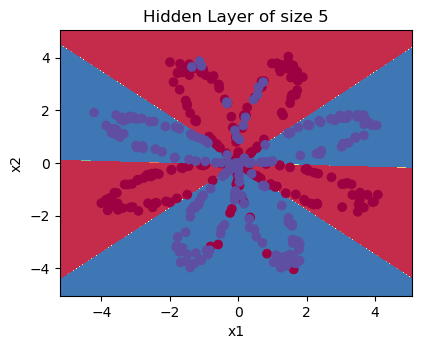

Accuracy for 5 hidden units: 91.25 %


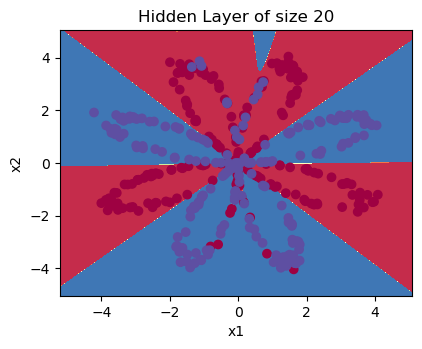

Accuracy for 20 hidden units: 90.0 %


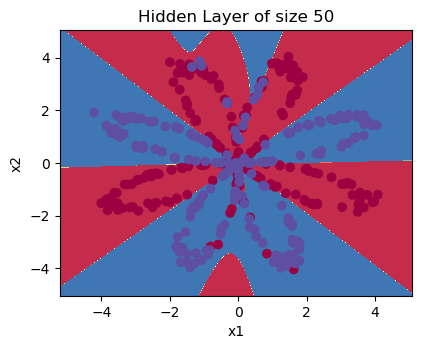

Accuracy for 50 hidden units: 90.25 %


In [110]:
# This may take about 2 minutes to run

plt.figure(figsize=(10, 20))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.figure(figsize=(10, 20))
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary( X, Y,lambda x: predict(parameters, x.T))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticeable overfitting.
- You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting.